# SIT744 Assignment 2: Deep Learning Project 

## Importing required libraries

In [1]:
import numpy as np
import pandas as pd 
import random
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow.keras.applications.xception as xception
import zipfile
import sys
import time
import tensorflow.keras as keras
import tensorflow as tf
import re

from PIL import Image
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, MaxPooling2D, Input, GlobalAveragePooling2D
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Lambda
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from datetime import datetime
from packaging import version

import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'

print('setup successful!')

setup successful!


In [2]:
# check whether I am using GPU processing power
device_name = tf.test.gpu_device_name()
if not device_name:
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
# Checking for Tensorflow version
print("TensorFlow version: ", tf.__version__)

TensorFlow version:  2.8.0


## **Task 1 (P Task) Smart Recycling using Deep Learning**

### Task 1.1 Define a problem (EDITT)

__Define an image classification problem that may help people better recycle, particularly by reducing contamination.__

While recycling may seem as simple as throwing our waste to a bin and waiting for it to be send to a plant to perform it's magical processes, it may not be the case most of the times. As according to the United States'Environmental Protection Agency (EPA) seems to agree that the estimated 75% of American waste is recyclable but only 30% of it is actually recycled[1]. Moreover, according to CBC, contamination is the technical name for non-recyclable material or garbage in the recycling system, from leftover food in containers to non-recyclable plastic packaging to more obvious garbage such as clothing and propane tanks. For example, major cities such as Toronto have a contamination rate as high as 25%, which essentially turns recycling materials into unrecyclable waste[2]. 

One of the issues with recycling that may be solve with AI-driven model is the issue of improper sorting. Consumers may struggle to determine the composition of waste goods due to the multitude of waste-material types and varying rules, and so incorrectly designate an item as recyclable or non-recyclable. Mixing recyclable and non-recyclable goods lowers the value of to-be-recycled materials and makes it more difficult to sell them, as well as increasing the volume of recyclables that end up in landfills. As a result, one potential AI application is the use of picture classification to identify and assist consumers in recognising the material composition of their trash items and, as a result, their recyclability.

__Describe the desired inputs and outputs, including the target classes.__

The desire input for this problem would be a wide variety of image of recylable materials such as, metal, aluminium, cardboxes, etc. Then the target classes would be the correct label of that particular image that we are trying to train. 

### Task 1.2 Make a plan

__What dataset can you use to develop a deep learning solution?__

The data that I will be using to develop a deep learning solution were obtained from Kaggle called "Garbage Classification"[3]. It consist of 15150 images with 12 different classes of household garbage; paper, cardboard, biological, metal, plastic, green-glass, brown-glass, white-glass, clothes, shoes, batteries, and trash.

__How many images do you need? How many for training? How many for testing?__

I will be splitting the dataset into 80% train set, 10% cross validation set, and 10% test set. 

__How do you determine if your model is good enough?__

In order to determine if our model is good enough, we can develop a baseline model where it is a simple and well understood procedure for making predictions on your predictive modelling problem. The performance of te model provides the bedrock for the lowest acceptable performance of a machine learning model on my specific dataset. The results of the baseline model provide the point from which the performance of all other models trained on my data can be evaluate. And of course, another typical way of evaluatig our model performance is the accuracy metric. However, we have to know that all modelling problem has prediction error, where it can come from a wide range of sources such as incompleteness of data sample, noise in the data and the stochastic nature of the modelling algorithm.

### Task 1.3 Implement a solution

__Collect relevant data, Develop a deep learning model, Report the model performance against the success criteria that you define.__

#### Defining constant

In [3]:
# Increasing the image size didn't result in increasing the training accuracy
IMAGE_WIDTH = 320    
IMAGE_HEIGHT = 320
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3

# Path where our data is located
base_path = "C:/Users/Hugh/Desktop/Master/T1 2022/SIT744 Deep learning/Assignment 2/garbage-data/garbage_classification/"


# Dictionary to save our 12 classes
categories = {0: 'paper', 1: 'cardboard', 2: 'plastic', 3: 'metal', 4: 'trash', 5: 'battery',
              6: 'shoes', 7: 'clothes', 8: 'green-glass', 9: 'brown-glass', 10: 'white-glass',
              11: 'biological'}

print('defining constants successful!')

defining constants successful!


#### Creating a dataframe

Now we are creating a dataframe that has in one columnthe filenames of all our images and in the other column the corresponding category. We open the directories in the dataset one by one, save the filenames in the filename_list and add the corresponding category in the categories_list.

In [4]:
# Add class name prefix to filename. So for example "/paper104.jpg" become "paper/paper104.jpg"
def add_class_name_prefix(df, col_name):
    df[col_name] = df[col_name].apply(lambda x: x[:re.search("\d",x).start()] + '/' + x)
    return df

# list conatining all the filenames in the dataset
filenames_list = []
# list to store the corresponding category, note that each folder of the dataset has one class of data
categories_list = []

for category in categories:
    filenames = os.listdir(base_path + categories[category])
    
    filenames_list = filenames_list  +filenames
    categories_list = categories_list + [category] * len(filenames)
    
df = pd.DataFrame({
    'filename': filenames_list,
    'category': categories_list
})

df = add_class_name_prefix(df, 'filename')

# Shuffle the dataframe
df = df.sample(frac=1).reset_index(drop=True)

print('number of elements = ' , len(df))

number of elements =  15515


In [5]:
df.head()

,filename,category
0,metal/metal391.jpg,3
1,clothes/clothes1453.jpg,7
2,white-glass/white-glass432.jpg,10
3,metal/metal331.jpg,3
4,plastic/plastic501.jpg,2


cardboard/cardboard600.jpg


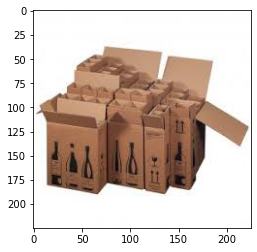

In [6]:
# see sample image, you can run the same cell again to get a different image
random_row = random.randint(0, len(df)-1)
sample = df.iloc[random_row]
randomimage = image.load_img(base_path +sample['filename'])
print(sample['filename'])
plt.imshow(randomimage)

#### Visualising categories distribution

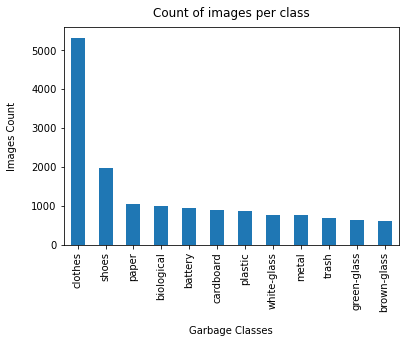

In [7]:
df_visualization = df.copy()
# Change the catgegories from numbers to names
df_visualization['category'] = df_visualization['category'].apply(lambda x:categories[x] )

df_visualization['category'].value_counts().plot.bar(x = 'count', y = 'category' )

plt.xlabel("Garbage Classes", labelpad=14)
plt.ylabel("Images Count", labelpad=14)
plt.title("Count of images per class", y=1.02);

#### Building a model 

The steps are:

1. Create an xception model without the last layer and load the ImageNet pretrained weights
2. Add a pre-processing layer
3. Add a pooling layer followed by a softmax layer at the end

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
import tensorflow.keras.applications.xception as xception

xception_layer = xception.Xception(include_top = False, input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT,IMAGE_CHANNELS),
                       weights = 'C:/Users/Hugh/Desktop/Master/T1 2022/SIT744 Deep learning/Assignment 2/xceptron/xception_weights_tf_dim_ordering_tf_kernels_notop.h5')

# We don't want to train the imported weights
xception_layer.trainable = False


model = Sequential()
model.add(keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))

#create a custom layer to apply the preprocessing
def xception_preprocessing(img):
  return xception.preprocess_input(img)

model.add(Lambda(xception_preprocessing))

model.add(xception_layer)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(Dense(len(categories), activation='softmax')) 

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 320, 320, 3)       0         
                                                                 
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 12)                24588     
                                                                 
Total params: 20,886,068
Trainable params: 24,588
Non-trainable params: 20,861,480
_________________________________________________________________


We will use the EarlyStopping call back to stop our training if the validation_accuray is not improving for a certain number of epochs.

In [9]:
early_stop = EarlyStopping(patience = 2, verbose = 1, monitor='val_categorical_accuracy' , mode='max', min_delta=0.001, restore_best_weights = True)

callbacks = [early_stop]

print('call back defined!')

call back defined!


#### Splitting the dataset

We are splitting the training set into 3 different sets:
1. The training set
2. The validation set
3. The test set

As mentioned earlier, we are splitting the data set as follows: 80% train set, 10% cross validation set, and 10% test set

In [21]:
#Change the categories from numbers to names
df["category"] = df["category"].replace(categories) 

# We first split the data into two sets and then split the validate_df to two sets
train_df, validate_df = train_test_split(df, test_size=0.2, random_state=42)
validate_df, test_df = train_test_split(validate_df, test_size=0.5, random_state=42)

train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

print('train size = ', total_validate , 'validate size = ', total_validate, 'test size = ', test_df.shape[0])

train size =  1551 validate size =  1551 test size =  1552


#### Training the model

We will first create the training data generator, that will get the images from the input data directory to train on them. We will also create a generator for the validation set. Although I have included ImageDataGenerator, I am not doing data augmentation until the next task. 

In [22]:
batch_size=64

train_datagen = image.ImageDataGenerator()

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    base_path, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 12412 validated image filenames belonging to 12 classes.


In [23]:
validation_datagen = image.ImageDataGenerator()

validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    base_path, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 1551 validated image filenames belonging to 12 classes.


In [24]:
EPOCHS = 20
history = model.fit(
    train_generator, 
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/20
193/193 [==============================] - 148s 729ms/step - loss: 0.6131 - categorical_accuracy: 0.8413 - val_loss: 0.3225 - val_categorical_accuracy: 0.9160
Epoch 2/20
193/193 [==============================] - 317s 2s/step - loss: 0.2397 - categorical_accuracy: 0.9384 - val_loss: 0.2454 - val_categorical_accuracy: 0.9290
Epoch 3/20
193/193 [==============================] - 369s 2s/step - loss: 0.1853 - categorical_accuracy: 0.9506 - val_loss: 0.2170 - val_categorical_accuracy: 0.9401
Epoch 4/20
193/193 [==============================] - 374s 2s/step - loss: 0.1550 - categorical_accuracy: 0.9576 - val_loss: 0.2071 - val_categorical_accuracy: 0.9408
Epoch 5/20
193/193 [==============================] - 502s 3s/step - loss: 0.1344 - categorical_accuracy: 0.9624 - val_loss: 0.1861 - val_categorical_accuracy: 0.9421
Epoch 6/20
193/193 [==============================] - 1022s 5s/step - loss: 0.1184 - categorical_accuracy: 0.9678 - val_loss: 0.1783 - val_categorical_accuracy: 0

In [25]:
model.save_weights("model.h5")

#### Visualising the training process

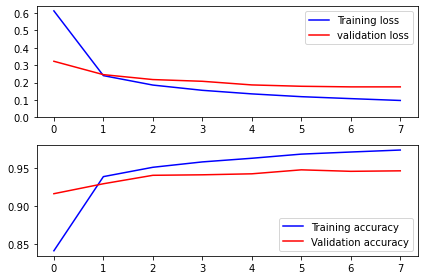

In [26]:
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_yticks(np.arange(0, 0.7, 0.1))
ax1.legend()

ax2.plot(history.history['categorical_accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_categorical_accuracy'], color='r',label="Validation accuracy")
ax2.legend()

legend = plt.legend(loc='best')
plt.tight_layout()
plt.show()

#### Evaluating the test results

To assess our model's performance, we'll develop a test generator that will load images from the input data directory and assess the results.

In [27]:
test_datagen = image.ImageDataGenerator()

test_generator = test_datagen.flow_from_dataframe(
    dataframe= test_df,
    directory=base_path,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    color_mode="rgb",
    class_mode="categorical",
    batch_size=1,
    shuffle=False 
)

Found 1552 validated image filenames belonging to 12 classes.


In [28]:
filenames = test_generator.filenames
nb_samples = len(filenames)

_, accuracy = model.evaluate_generator(test_generator, nb_samples)

print('accuracy on test set = ',  round((accuracy * 100),2 ), '% ') 

C:\Users\Hugh\AppData\Local\Temp\ipykernel_17172\79043940.py:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  _, accuracy = model.evaluate_generator(test_generator, nb_samples)


accuracy on test set =  95.49 % 


We can see that our test results shows an accuracy of over 95% which mean that our model is performing relatively well. Now we will look at the F1 score for each of the garbage categories, which we will use classification report function in the sklearn module.

In [24]:
# We defined at the beginning of this notebook a dictionary that maps the categories number to names, but the train generator
# generated it's own dictionary and it has assigned different numbers to our categories and the predictions made by the model 
# will be made using the genrator's dictionary.

gen_label_map = test_generator.class_indices
gen_label_map = dict((v,k) for k,v in gen_label_map.items())
print(gen_label_map)

NameError: name 'test_generator' is not defined

In [21]:
# get the model's predictions for the test set
preds = model.predict_generator(test_generator, nb_samples)

# Get the category with the highest predicted probability, the prediction is only the category's number and not name
preds = preds.argmax(1)

# Convert the predicted category's number to name 
preds = [gen_label_map[item] for item in preds]

# Convert the pandas dataframe to a numpy matrix
labels = test_df['category'].to_numpy()

print(classification_report(labels, preds))

C:\Users\Hugh\AppData\Local\Temp\ipykernel_2648\727984934.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(test_generator, nb_samples)


              precision    recall  f1-score   support

     battery       0.96      0.97      0.96        93
  biological       0.99      1.00      0.99        82
 brown-glass       0.91      0.87      0.89        68
   cardboard       0.94      0.93      0.93        96
     clothes       0.99      0.99      0.99       533
 green-glass       0.96      0.89      0.92        72
       metal       0.89      0.90      0.89        87
       paper       0.91      0.96      0.93        94
     plastic       0.89      0.82      0.85        78
       shoes       0.98      1.00      0.99       206
       trash       0.97      0.93      0.95        70
 white-glass       0.82      0.93      0.87        73

    accuracy                           0.95      1552
   macro avg       0.93      0.93      0.93      1552
weighted avg       0.95      0.95      0.95      1552



The F1 score of each category is shown in the table above, among other things. Notice the two numbers accuracy and macro average at the bottom of the F1 score column. Accuracy is a weighted average of the accuracy we examined above for the test set.

Thus, based on the model I have developed, I can say that it is performing very well over my expectation.

## **Task 2 (C Task) Analyse and improve the model**

### Task 2.1 Build an input pipeline for data augmentation


Build a data preprocessing pipeline to perform data augmentation. (You may use Keras ImageDataGenerator or write your own transformations.)

- Report the model performance with the pipeline added. How much performance gain have you achieved?    

- Profile your input pipeline to identify the most time-consuming operation. What actions have you taken to address that slow operation? (*Hint: You may use a profiler such as the [TensorFlow Profiler](https://github.com/tensorflow/profiler).*)

In [14]:
batch_size=64

# Data augmentation starts
train_datagen2 = image.ImageDataGenerator(    
    rotation_range=30,
    shear_range=0.1,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip = True,
    width_shift_range=0.2,
    height_shift_range=0.2
)
# Data augmentation ends

train_generator2 = train_datagen2.flow_from_dataframe(
    train_df, 
    base_path, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 12412 validated image filenames belonging to 12 classes.


In [15]:
validation_datagen2 = image.ImageDataGenerator()

validation_generator2 = validation_datagen2.flow_from_dataframe(
    validate_df, 
    base_path, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 1551 validated image filenames belonging to 12 classes.


In [16]:
# Create a TensorBoard callback
logs = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")

tboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logs,
                                                 histogram_freq = 1,
                                                 profile_batch = '500,520')

In [17]:
EPOCHS = 20
history2 = model.fit(
    train_generator2, 
    epochs=EPOCHS,
    validation_data=validation_generator2,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
     callbacks = [tboard_callback]
)

Epoch 1/20
193/193 [==============================] - 190s 956ms/step - loss: 0.7811 - categorical_accuracy: 0.7851 - val_loss: 0.3455 - val_categorical_accuracy: 0.9121
Epoch 2/20
193/193 [==============================] - 176s 911ms/step - loss: 0.3657 - categorical_accuracy: 0.8963 - val_loss: 0.2656 - val_categorical_accuracy: 0.9193
Epoch 3/20
193/193 [==============================] - 176s 909ms/step - loss: 0.3051 - categorical_accuracy: 0.9083 - val_loss: 0.2295 - val_categorical_accuracy: 0.9271
Epoch 4/20
193/193 [==============================] - 177s 913ms/step - loss: 0.2754 - categorical_accuracy: 0.9155 - val_loss: 0.2113 - val_categorical_accuracy: 0.9349
Epoch 5/20
193/193 [==============================] - 189s 977ms/step - loss: 0.2473 - categorical_accuracy: 0.9244 - val_loss: 0.1984 - val_categorical_accuracy: 0.9401
Epoch 6/20
193/193 [==============================] - 182s 942ms/step - loss: 0.2406 - categorical_accuracy: 0.9263 - val_loss: 0.1899 - val_categoric

In [18]:
model.save_weights("model2.h5")

#### Use the TensorFlow Profiler to profile model training performance

In [19]:
# Load the TensorBoard notebook extension.
%reload_ext tensorboard

In [20]:
# Launch TensorBoard and navigate to the Profile tab to view performance profile
%tensorboard --logdir=logs

Reusing TensorBoard on port 6006 (pid 16860), started 3:23:48 ago. (Use '!kill 16860' to kill it.)

#### Evaluating the test results

In [21]:
test_datagen2 = image.ImageDataGenerator()

test_generator2 = test_datagen2.flow_from_dataframe(
    dataframe= test_df,
    directory=base_path,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    color_mode="rgb",
    class_mode="categorical",
    batch_size=1,
    shuffle=False 
)

Found 1552 validated image filenames belonging to 12 classes.


In [22]:
filenames = test_generator2.filenames
nb_samples = len(filenames)

_, accuracy = model.evaluate_generator(test_generator2, nb_samples)

print('accuracy on test set = ',  round((accuracy * 100),2 ), '% ') 

C:\Users\Hugh\AppData\Local\Temp\ipykernel_29232\1768348745.py:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  _, accuracy = model.evaluate_generator(test_generator2, nb_samples)


accuracy on test set =  94.78 % 


As we can see based on the results, the accuracy on test test is 95% as well. There is not much differences in performance when the model has data augmentation or without it.

In [25]:
# We defined at the beginning of this notebook a dictionary that maps the categories number to names, but the train generator
# generated it's own dictionary and it has assigned different numbers to our categories and the predictions made by the model 
# will be made using the genrator's dictionary.

gen_label_map = test_generator2.class_indices
gen_label_map = dict((v,k) for k,v in gen_label_map.items())
print(gen_label_map)

# get the model's predictions for the test set
preds = model.predict_generator(test_generator2, nb_samples)

# Get the category with the highest predicted probability, the prediction is only the category's number and not name
preds = preds.argmax(1)

# Convert the predicted category's number to name 
preds = [gen_label_map[item] for item in preds]

# Convert the pandas dataframe to a numpy matrix
labels = test_df['category'].to_numpy()

print(classification_report(labels, preds))

{0: 'battery', 1: 'biological', 2: 'brown-glass', 3: 'cardboard', 4: 'clothes', 5: 'green-glass', 6: 'metal', 7: 'paper', 8: 'plastic', 9: 'shoes', 10: 'trash', 11: 'white-glass'}


C:\Users\Hugh\AppData\Local\Temp\ipykernel_29232\365224035.py:10: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(test_generator2, nb_samples)


              precision    recall  f1-score   support

     battery       0.97      0.97      0.97        95
  biological       0.96      0.98      0.97        90
 brown-glass       0.89      0.88      0.88        74
   cardboard       0.98      0.87      0.92        91
     clothes       1.00      0.99      0.99       539
 green-glass       0.90      0.85      0.87        61
       metal       0.76      0.97      0.86        70
       paper       0.90      0.92      0.91        93
     plastic       0.89      0.79      0.84        85
       shoes       0.96      1.00      0.98       201
       trash       0.97      0.99      0.98        75
 white-glass       0.91      0.86      0.88        78

    accuracy                           0.95      1552
   macro avg       0.92      0.92      0.92      1552
weighted avg       0.95      0.95      0.95      1552



### Task 2.2 Compare the performance under equal training time

You may notice that with your pipeline, the model performance improves, but at the cost of a longer training time per epoch. Is the additional training time well spent? Compare the dynamic of model performance (e.g., classification accuracy on the test data) with and without data augmentation, when equal training time is spent in the two scenarios. 

As we can see in our classification report for the model that has performed image augmentation, some of the categories such as clothes and metal has a better performance based on precision and a slightly better marginal scores as well. However, the training time between two models differs significantly. For example, in our first model, one epoch took approximately 70s to run whereas in our second model it took 180s on average to run. In my opinion, with my current computational power (RTX3060) the improvement in the second model is quite marginal and it does not justify the use of data augmentation with a significantly longer training time. 

### Task 2.3 Identifying model strength and weakness

Identify images that are incorrectly classified by your model. Do they share something in common? How do you plan to improve the model's performance on those images? 

The macro avg (unweighted average) is, however, slightly less than accuracy. Because the clothing category, which contains by far the most photos, has a high F1 score, accuracy (the weighted average) is higher than the unweighted average (macro avg).

For this case, I believe the macro avg is a better measure of accuracy because it averages all of the F1 scores, regardless of how much data is in the training set for each category. The other weakness of this model is that it is a complex model to train model and can accomplish multiple processes simulateously but it requires a decent graphical processing unit (GPU), otherwise, it will take a long time to go through one images alone. Because CNN works by assessing an image's distinguishing qualities, it's clear that it's perfect for security checks and other similar applications. Regardless of how wonderful it seems, without the proper instruction, this might potentially backfire.

Because it relies only on distinguishing traits, it is readily fooled into believing that one thing is actually another. So, even if the 'distinct aspects' of an image are ordered differently, CNN will still match it to the original.

On the plus side, CNN's incorrect translations can be trained out. After all, while a few lines of code won't be able to duplicate human behaviour, neural networks are modelled after human cognitive capabilities. As a result, it is still capable of learning. However, similar to teaching a toddler, this training phase may take a long time, especially if your GPU isn't the best. As a result, you must prepare yourself for this difficult task ahead of time[4].

As image classification and identification are CNN's area of expertise. Although the image was tampered with or some parts of it were edited out, CNN can still pull out the original image as long as its distinct features remain. Moreover, ConvNets, as previously said, is fully capable of evaluating and processing data utilising its built-in intuition. As a result, you may expect it to grow even more over time. When consumers continue to provide it the same type of data, this can be highly useful.

Unlike artificial intelligence, ConvNets—and neural networks in general—would utilise their algorithm to interpret data 'outside the box,' rather than approaching it in the same manner every time. As a result, it will have greater room to develop its powers. CNNs are expected to hold massive amounts of data because they are designed to conduct numerous tasks at once. However, because CNN's aim is to filter through every piece of input data, you don't have to worry about meaningless data clogging up the system. As a result, ConvNets makes sure that its enormous storage is put to good use.

## **Task 3 (D Task) Improve model generalisability across domains**

Show sample images from the original test data and the newly collected test data. In what ways are they different?

Feed the new test data into your model. Report the performance change.

Improve your model so that it generalises better on unseen test images.

In this part, I have found a variety of scrap data from various sources such as google images, images from my phone, kaggle, etc. All images were arrange according to its respective classes (12 classes) and in the same directory as my previous model. There are a total of 7397 new images in this section of the task.

We will perform the same pre-processing steps is previous model and use the same model that we have developed and compare its performance. 

### Defining Constant

In [10]:
# Increasing the image size didn't result in increasing the training accuracy
IMAGE_WIDTH = 320    
IMAGE_HEIGHT = 320
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3

# Path where our data is located
base_path2 = "C:/Users/Hugh/Desktop/Master/T1 2022/SIT744 Deep learning/Assignment 2/garbageNewImage/"


# Dictionary to save our 12 classes
categories = {0: 'paper', 1: 'cardboard', 2: 'plastic', 3: 'metal', 4: 'trash', 5: 'battery',
              6: 'shoes', 7: 'clothes', 8: 'green-glass', 9: 'brown-glass', 10: 'white-glass',
              11: 'biological'}

print('defining constants successful!')

defining constants successful!


### Creating a dataframe

In [11]:
# Add class name prefix to filename. So for example "/paper104.jpg" become "paper/paper104.jpg"
def add_class_name_prefix(df, col_name):
    df[col_name] = df[col_name].apply(lambda x: x[:re.search("\d",x).start()] + '/' + x)
    return df

# list containing all the filenames in the dataset
filenames_list = []
# list to store the corresponding category, note that each folder of the dataset has one class of data
categories_list = []

for category in categories:
    filenames = os.listdir(base_path2 + categories[category])
    
    filenames_list = filenames_list  +filenames
    categories_list = categories_list + [category] * len(filenames)
    
df2 = pd.DataFrame({
    'filename': filenames_list,
    'category': categories_list
})

df2 = add_class_name_prefix(df2, 'filename')

# Shuffle the dataframe
df2 = df2.sample(frac=1).reset_index(drop=True)

print('number of elements = ' , len(df2))

number of elements =  120


clothes/clothes4259.jpg


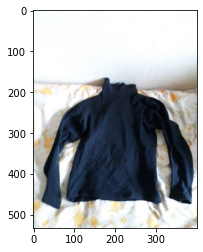

In [12]:
# see sample image, you can run the same cell again to get a different image
random_row = random.randint(0, len(df2)-1)
sample = df2.iloc[random_row]
randomimage = image.load_img(base_path2 +sample['filename'])
print(sample['filename'])
plt.imshow(randomimage)

### Visualising new images categories distribution

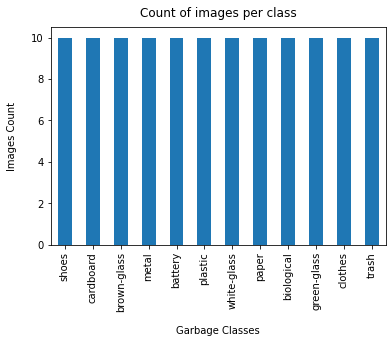

In [13]:
df_visualization = df2.copy()
# Change the catgegories from numbers to names
df_visualization['category'] = df_visualization['category'].apply(lambda x:categories[x] )

df_visualization['category'].value_counts().plot.bar(x = 'count', y = 'category' )

plt.xlabel("Garbage Classes", labelpad=14)
plt.ylabel("Images Count", labelpad=14)
plt.title("Count of images per class", y=1.02);

As we can see for this time, the distributions of the new images are different, clothes does not have the high count anymore.

### Fitting the same model

Here we can using the same model that does not include data augmentation steps as we have seen previously. 

In [58]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
import tensorflow.keras.applications.xception as xception

xception_layer = xception.Xception(include_top = False, input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT,IMAGE_CHANNELS),
                       weights = 'C:/Users/Hugh/Desktop/Master/T1 2022/SIT744 Deep learning/Assignment 2/xceptron/xception_weights_tf_dim_ordering_tf_kernels_notop.h5')

# We don't want to train the imported weights
xception_layer.trainable = False


model = Sequential()
model.add(keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))

#create a custom layer to apply the preprocessing
def xception_preprocessing(img):
  return xception.preprocess_input(img)

model.add(Lambda(xception_preprocessing))

model.add(xception_layer)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(Dense(len(categories), activation='softmax')) 

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 320, 320, 3)       0         
                                                                 
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 12)                24588     
                                                                 
Total params: 20,886,068
Trainable params: 24,588
Non-trainable params: 20,861,480
_________________________________________________________________


### Defining callbacks and splitting the dataset

In [29]:
early_stop = EarlyStopping(patience = 2, verbose = 1, monitor='val_categorical_accuracy' , mode='max', min_delta=0.001, restore_best_weights = True)

callbacks = [early_stop]

print('call back defined!')

#Change the categories from numbers to names
df2["category"] = df2["category"].replace(categories) 

# # We first split the data into two sets and then split the validate_df to two sets
# train_df_2, validate_df_2 = train_test_split(df2, test_size=0.2, random_state=42)
# validate_df_2, test_df_2 = train_test_split(validate_df_2, test_size=0.5, random_state=42)

# train_df_2 = train_df_2.reset_index(drop=True)
# validate_df_2 = validate_df_2.reset_index(drop=True)
# test_df_2 = test_df_2.reset_index(drop=True)

# total_train2 = train_df_2.shape[0]
# total_validate2 = validate_df_2.shape[0]

# print('train size = ', total_train2 , 'validate size = ', total_validate2, 'test size = ', test_df_2.shape[0])

call back defined!


### Training the model

In [62]:
# batch_size=64

# train_datagen = image.ImageDataGenerator()

# train_generator = train_datagen.flow_from_dataframe(
#     train_df_2, 
#     base_path2, 
#     x_col='filename',
#     y_col='category',
#     target_size=IMAGE_SIZE,
#     class_mode='categorical',
#     batch_size=batch_size
# )

# validation_datagen = image.ImageDataGenerator()

# validation_generator = validation_datagen.flow_from_dataframe(
#     validate_df_2, 
#     base_path2, 
#     x_col='filename',
#     y_col='category',
#     target_size=IMAGE_SIZE,
#     class_mode='categorical',
#     batch_size=batch_size
# )

Found 5917 validated image filenames belonging to 12 classes.
Found 740 validated image filenames belonging to 12 classes.


In [64]:
# EPOCHS = 20
# history = model.fit(
#     train_generator, 
#     epochs=EPOCHS,
#     validation_data=validation_generator,
#     validation_steps=total_validate2//batch_size,
#     steps_per_epoch=total_train2//batch_size,
#     callbacks=callbacks
# )

Epoch 1/20
92/92 [==============================] - 46s 408ms/step - loss: 0.9938 - categorical_accuracy: 0.7617 - val_loss: 0.4823 - val_categorical_accuracy: 0.8878
Epoch 2/20
92/92 [==============================] - 36s 391ms/step - loss: 0.4140 - categorical_accuracy: 0.8966 - val_loss: 0.3582 - val_categorical_accuracy: 0.9048
Epoch 3/20
92/92 [==============================] - 36s 393ms/step - loss: 0.3195 - categorical_accuracy: 0.9137 - val_loss: 0.3066 - val_categorical_accuracy: 0.9134
Epoch 4/20
92/92 [==============================] - 36s 394ms/step - loss: 0.2676 - categorical_accuracy: 0.9265 - val_loss: 0.2781 - val_categorical_accuracy: 0.9219
Epoch 5/20
92/92 [==============================] - 36s 395ms/step - loss: 0.2334 - categorical_accuracy: 0.9356 - val_loss: 0.2635 - val_categorical_accuracy: 0.9190
Epoch 6/20
92/92 [==============================] - 36s 395ms/step - loss: 0.2061 - categorical_accuracy: 0.9428 - val_loss: 0.2457 - val_categorical_accuracy: 0.923

### Evaluating the test result

In [30]:
test_datagen = image.ImageDataGenerator()

test_generator = test_datagen.flow_from_dataframe(
    dataframe= df2,
    directory=base_path2,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    color_mode="rgb",
    class_mode="categorical",
    batch_size=1,
    shuffle=False 
)
filenames = test_generator.filenames
nb_samples = len(filenames)

_, accuracy = model.evaluate_generator(test_generator, nb_samples)

print('accuracy on test set = ',  round((accuracy * 100),2 ), '% ')

Found 120 validated image filenames belonging to 12 classes.


C:\Users\Hugh\AppData\Local\Temp\ipykernel_17172\1646367056.py:17: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  _, accuracy = model.evaluate_generator(test_generator, nb_samples)


accuracy on test set =  86.67 % 


In [14]:
# Saving the model
tf.keras.models.save_model(model,'my_model.hdf5')

By feeding new data

## **Task 4 (HD Task) Build a workable prototype**

Build a web/mobile app that people from your city council can use to determine what to recycle. Test your prototype with the target users and report their feedback.

Upload your code into a GitHub repository.

Create a short video presentation about your product.

### Creating a Streamlit Web App

In [ ]:
from flask import Flask, request, jsonify
import numpy as np
import pickle
model = pickle.load(open('model.pkl', 'rb'))
app = Flask(Garbage)

@app.route('/')
def index():
    return "hello world"
@app.route('/predict', methods = ['POST'])
def predict():
    c

## References

[1] Wang, D. (2021, July 23). How AI Can Help Us Recycle. Medium. https://towardsdatascience.com/how-ai-can-help-us-recycle-c2f82d0d50de#83d7

[2] Waste and Recycling in North America. (2019, November 19). GPetrium. https://www.gpetrium.com/waste-and-recycling-in-north-america/#:~:text=The%20United%20States

[3] CCHANG. (2018). <i>Garbage Classification</i> [Data set]. Kaggle. https://doi.org/10.34740/KAGGLE/DS/81794

[4]D. Thompson, "The Pros And Cons Of Convolution Neural Networks", iTech Post, 2022. [Online]. Available: https://www.itechpost.com/articles/109452/20220307/the-pros-and-cons-of-convolution-neural-networks.htm. [Accessed: 25- Apr- 2022].